In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import collections
import csv
import numpy
import pandas as pd
import efficientnet.keras as efn
from collections import Counter
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [2]:
train_path= 'train'
valid_path = 'valid'
test_path = 'test'
train_batches = ImageDataGenerator(rescale = 1.0/255.,zoom_range=0.2).flow_from_directory(directory=train_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)
test_batches = ImageDataGenerator(rescale = 1.0/255.).flow_from_directory(directory=test_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10,shuffle=False)
valid_batches = ImageDataGenerator(rescale = 1.0/255.).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)


Found 3934 images belonging to 4 classes.
Found 833 images belonging to 4 classes.
Found 892 images belonging to 4 classes.


In [3]:
imgs, labels = next(train_batches)

In [4]:
#plot images 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr , axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

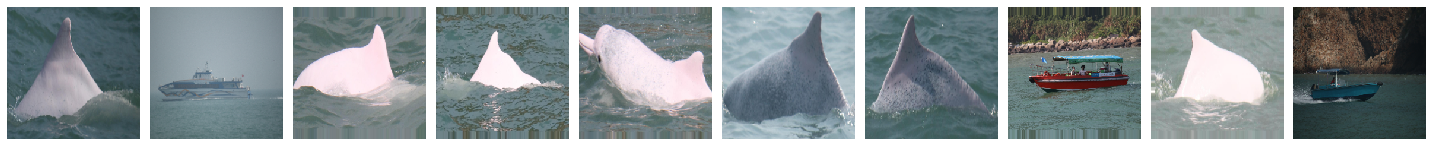

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [5]:
plotImages(imgs)
print(labels)


In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# efficientnet
##### https://github.com/Tony607/efficientnet_keras_transfer_learning/blob/master/Keras_efficientnet_transfer_learning.ipynb

In [7]:
base_model = efn.EfficientNetB7(weights = 'imagenet', include_top=False , input_shape=(224,224,3))
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [8]:
model=Sequential()
model.add(base_model)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(Dense(300, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()
        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_max_pooling2d (Global (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               768300    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3

In [9]:
base_model.trainable=False

In [10]:
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers after freezing the conv base: 10


In [11]:
counter = Counter(train_batches.classes)
max_val = float(max(counter.values()))
class_weights={class_id : max_val/num_images for class_id, num_images in counter.items()}
print(class_weights)

{0: 1.0, 1: 15.104575163398692, 2: 2.9105793450881614, 3: 3.418639053254438}


In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history_1=model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=20,verbose=2)

Epoch 1/20
394/394 - 573s - loss: 4.7461 - accuracy: 0.3124 - val_loss: 1.0345 - val_accuracy: 0.5717
Epoch 2/20
394/394 - 538s - loss: 4.1865 - accuracy: 0.3744 - val_loss: 1.1344 - val_accuracy: 0.4798
Epoch 3/20
394/394 - 537s - loss: 3.7135 - accuracy: 0.4118 - val_loss: 1.0695 - val_accuracy: 0.5717
Epoch 4/20
394/394 - 538s - loss: 3.5254 - accuracy: 0.4235 - val_loss: 1.0756 - val_accuracy: 0.5639
Epoch 5/20
394/394 - 538s - loss: 3.3437 - accuracy: 0.4362 - val_loss: 1.0880 - val_accuracy: 0.5617
Epoch 6/20
394/394 - 538s - loss: 3.2530 - accuracy: 0.4634 - val_loss: 1.1360 - val_accuracy: 0.5157
Epoch 7/20
394/394 - 538s - loss: 3.1724 - accuracy: 0.4771 - val_loss: 0.9963 - val_accuracy: 0.6054
Epoch 8/20
394/394 - 539s - loss: 3.0128 - accuracy: 0.4748 - val_loss: 1.0294 - val_accuracy: 0.5953
Epoch 9/20
394/394 - 536s - loss: 2.8944 - accuracy: 0.5033 - val_loss: 0.9671 - val_accuracy: 0.6166
Epoch 10/20
394/394 - 539s - loss: 2.8876 - accuracy: 0.4962 - val_loss: 1.0533 - 

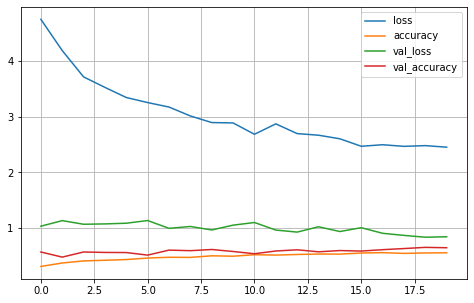

In [13]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Confusion matrix, without normalization
[[299   3   0 155]
 [ 27  46  15   1]
 [ 93  68  34  44]
 [  0   0   0  48]]


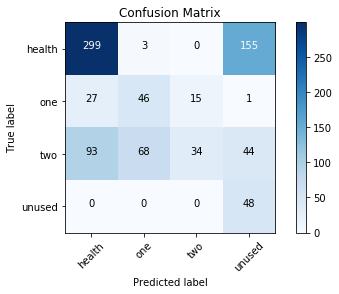

In [14]:
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [15]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = model.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       457
           1       0.39      0.52      0.45        89
           2       0.69      0.14      0.24       239
           3       0.19      1.00      0.32        48

    accuracy                           0.51       833
   macro avg       0.50      0.58      0.42       833
weighted avg       0.64      0.51      0.51       833



In [16]:
model.save('efficientnetb7_v2_one_unused_augmented_regularisation.h5')

# finetuning

In [17]:
for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history_2=model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=20,verbose=2)

Epoch 1/20
394/394 - 1820s - loss: 2.7968 - accuracy: 0.5066 - val_loss: 2.5873 - val_accuracy: 0.3139
Epoch 2/20
394/394 - 1774s - loss: 2.1618 - accuracy: 0.5989 - val_loss: 3.3232 - val_accuracy: 0.2354
Epoch 3/20
394/394 - 1773s - loss: 2.0176 - accuracy: 0.6187 - val_loss: 4.1210 - val_accuracy: 0.1783
Epoch 4/20
394/394 - 1771s - loss: 1.7824 - accuracy: 0.6500 - val_loss: 4.0919 - val_accuracy: 0.1917
Epoch 5/20
394/394 - 1771s - loss: 1.7596 - accuracy: 0.6718 - val_loss: 4.0264 - val_accuracy: 0.1715
Epoch 6/20
394/394 - 1768s - loss: 1.7759 - accuracy: 0.6624 - val_loss: 4.6021 - val_accuracy: 0.1177
Epoch 7/20
394/394 - 1765s - loss: 1.6306 - accuracy: 0.6828 - val_loss: 5.2215 - val_accuracy: 0.1043
Epoch 8/20
394/394 - 1766s - loss: 1.6028 - accuracy: 0.6988 - val_loss: 3.6868 - val_accuracy: 0.1906
Epoch 9/20
394/394 - 1766s - loss: 1.5324 - accuracy: 0.7062 - val_loss: 5.6533 - val_accuracy: 0.1132
Epoch 10/20
394/394 - 1766s - loss: 1.4332 - accuracy: 0.7260 - val_loss:

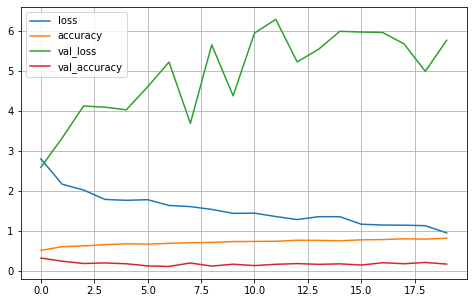

In [19]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Confusion matrix, without normalization
[[ 22   3   2 430]
 [  1  37   3  48]
 [  0  16   5 218]
 [  0   0   0  48]]


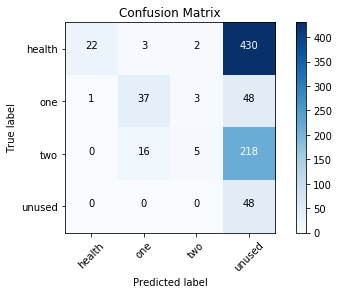

In [20]:
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [21]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = model.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.96      0.05      0.09       457
           1       0.66      0.42      0.51        89
           2       0.50      0.02      0.04       239
           3       0.06      1.00      0.12        48

    accuracy                           0.13       833
   macro avg       0.55      0.37      0.19       833
weighted avg       0.74      0.13      0.12       833



In [22]:
model.save('efficientnetb7_v2_crop.h5')

In [34]:
list_predictions=list(np.argmax(predictions, axis=-1))
list_filename = test_batches.filenames
final_predictions=[]
for item in zip(list_filename,list_predictions):
    final_predictions.append(item)

#predictions and labels 
arr = numpy.array(final_predictions)

# convert array into dataframe 
DF = pd.DataFrame(arr) 
  
# save the dataframe as a csv file 
DF.to_csv("efficientnetb7_finetune.csv")

In [35]:
list_unique=list(set(list_predictions))
print(list_unique)

[0, 1, 2, 3]
